<a href="https://www.kaggle.com/toutatsu/brain-tumor-efficientnet-3d?scriptVersionId=89265055" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

inference

https://www.kaggle.com/rluethy/efficientnet3d-with-one-mri-type

https://www.kaggle.com/chumajin/brain-tumor-eda-for-starter-version

https://www.kaggle.com/davidbroberts/determining-mr-image-planes

In [1]:
#defaul libraries
#https://docs.python.org/ja/
import os
import sys
import io

import math
import random
import pprint
import time
import datetime
import typing
import json
import glob
import requests
import warnings
import gc
from pprint import pprint
import re

import numpy as np #https://numpy.org/
import pandas as pd #https://pandas.pydata.org/
import sklearn #https://scikit-learn.org/stable/

import matplotlib.pyplot as plt #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
from matplotlib import animation, rc
rc('animation', html='jshtml')
%matplotlib inline

import seaborn as sns
sns.set()

from tqdm.auto import tqdm #https://tqdm.github.io/

import torch #https://pytorch.org/

sys.path.append("../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D")
from efficientnet_pytorch_3d import EfficientNet3D

# import torchvision
import cv2
from PIL import Image

import pydicom

In [2]:
class CFG():
    
    data_path="../input/rsna-miccai-brain-tumor-radiogenomic-classification/"
    debug=False
    seed=0

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size=4
    epochs=30
    learning_rate=0.0001
    kFold=5
    
    
    image_size=64

    #高速化関連
    #https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587

    #GPU 遅くなるらしい↓
    torch.backends.cudnn.deterministic = True

    #イテレーションごとのnnの順伝搬および誤差関数の 計算手法がある程度一定であれば、torch.backends.cudnn.benchmark = Trueで GPU での計算が高速化
    #torch.backends.cudnn.benchmark = False


def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)

print(CFG.device)
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name())

cuda
0
Tesla P100-PCIE-16GB


In [3]:
def color(string,fg='DEFAULT',bg='DEFAULT',fg_rgb=None,bg_rgb=None,style='END'):
    colors=['BLACK','RED','GREEN','YELLOW','BLUE','PURPLE','CYAN','WHITE','8','DEFAULT']
    styles=['END','BOLD','2','3','UNDERLINE','5','6','REVERSE','INVISIBLE','9']

    fg=f'\033[3{colors.index(fg)}m'
    bg=f'\033[4{colors.index(bg)}m'
    style=f'\033[0{styles.index(style)}m'

    if fg_rgb:fg=f"\033[38;2;{fg_rgb[0]};{fg_rgb[1]};{fg_rgb[2]}m"
    if bg_rgb:bg=f"\033[48;2;{bg_rgb[0]};{bg_rgb[1]};{bg_rgb[2]}m"

    return style+fg+bg+str(string)+'\033[0m'

In [4]:
labels={'train':None,'val':None,'test':None}
labels['train']=pd.read_csv(os.path.join(CFG.data_path,"train_labels.csv"),index_col='BraTS21ID').drop([109, 123, 709])
labels['test']=pd.read_csv(os.path.join(CFG.data_path,"sample_submission.csv"),index_col='BraTS21ID')

if CFG.debug:
    labels['train']=labels['train'].sample(frac=0.1)

In [5]:
from sklearn.model_selection import train_test_split
labels['train'], labels['val'] = sklearn.model_selection.train_test_split(
    labels['train'],
    test_size=0.2,
    random_state=CFG.seed, 
    stratify=labels['train']["MGMT_value"],
)

In [6]:
for phase in ['train','val','test']:
    phase_dir='test' if phase=='test' else 'train'
    labels[phase]["path"] = [
        os.path.join(*[CFG.data_path,phase_dir,str(index).zfill(5)]) for index in labels[phase].index
    ]

In [7]:
def BraTS21ID_phase(BraTS21ID):
    if BraTS21ID in labels['train'].index:return 'train'
    if BraTS21ID in labels['val'].index  :return 'val'
    if BraTS21ID in labels['test'].index :return 'test'

BraTS21ID_phase(102)

'val'

In [8]:
labels['train']

,MGMT_value,path
BraTS21ID,,
780,0,../input/rsna-miccai-brain-tumor-radiogenomic-...
371,1,../input/rsna-miccai-brain-tumor-radiogenomic-...
838,1,../input/rsna-miccai-brain-tumor-radiogenomic-...
214,0,../input/rsna-miccai-brain-tumor-radiogenomic-...
348,0,../input/rsna-miccai-brain-tumor-radiogenomic-...
...,...,...
112,0,../input/rsna-miccai-brain-tumor-radiogenomic-...
290,0,../input/rsna-miccai-brain-tumor-radiogenomic-...
391,0,../input/rsna-miccai-brain-tumor-radiogenomic-...


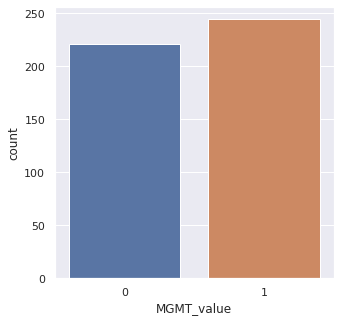

In [9]:
plt.figure(figsize=(5, 5))
sns.countplot(data=labels['train'], x="MGMT_value");

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,labels,phase='train',frame_per_brain=None):
        self.labels=labels
        self.phase=phase #train/val/test
        self.remove_black_boundary=True
        self.frame_per_brain=frame_per_brain
        
    def __len__(self):
        return len(self.labels)
    
    def images_path(self,BraTS21ID):
        """BraTS21ID に対応する患者のMRI画像のpathをまとめた DataFrame を返す"""
        df={"FLAIR":None,"T1w":None,"T1wCE":None,"T2w":None}
        for mri_type in ["FLAIR","T1w","T1wCE","T2w"]:
            #print(os.path.join(self.labels.loc[BraTS21ID].path,mri_type))
            folder_path=os.path.join(self.labels.loc[BraTS21ID].path,mri_type)
            dcm_files = os.listdir(folder_path)
            tmp_df = pd.DataFrame(
                {'image_path':[os.path.join(folder_path,dcm_file) for dcm_file in dcm_files]},
                index=[int(re.search('(\d+)',a).group()) for a in dcm_files],
            )
            tmp_df.sort_index(inplace=True)
            df[mri_type]=tmp_df
        return df
    
    def load_dicom(self,path,voi_lut=True,remove_black_boundary=True):
        """path で指定した MRI画像 を返す"""
        dicom = pydicom.read_file(path)
        data = dicom.pixel_array
        
        # VOI LUT (if available by DICOM device) is used to
        # transform raw DICOM data to "human-friendly" view
        if voi_lut:data = pydicom.pixel_data_handlers.util.apply_voi_lut(data, dicom)#??????????????
        
        # depending on this value, X-ray may look inverted - fix that:
        if dicom.PhotometricInterpretation == "MONOCHROME1":
            print('inverted')
            data = np.amax(data) - data
        
        data=data.astype(np.float32)
        data = data-np.min(data)
        if np.max(data)!=0 : data/=np.max(data)
        #data = (data * 255).astype(np.uint8)
        return cv2.resize(data, (CFG.image_size, CFG.image_size))

    def __getitem__(self,BraTS21ID):
        #print(f'fetching:{BraTS21ID}')
        df=self.images_path(BraTS21ID)
        mri_images={
            "FLAIR":np.ndarray((0,CFG.image_size,CFG.image_size),dtype=np.int),
            "T1w"  :np.ndarray((0,CFG.image_size,CFG.image_size),dtype=np.int),
            "T1wCE":np.ndarray((0,CFG.image_size,CFG.image_size),dtype=np.int),
            "T2w"  :np.ndarray((0,CFG.image_size,CFG.image_size),dtype=np.int)
        }
        #3次元ndarrayに画像を一枚ずつ追加
        for mri_type in ["FLAIR","T1w","T1wCE","T2w"]:
            
            for image_path in df[mri_type].image_path:
                image=self.load_dicom(image_path)
                image=np.reshape(image,(1,CFG.image_size,CFG.image_size)) # reshapeで追加先と同じ次元数にする
                mri_images[mri_type] = np.append(mri_images[mri_type], np.atleast_3d(image), axis=0)
                
            #真っ黒な画像　＆　周りの黒い領域を消す
            if self.remove_black_boundary:
                t,x,y=np.where(mri_images[mri_type]>0)
                ###train 123 T1w T2w 真っ暗
                if (len(t) == 0 or len(x) == 0 or len(y) == 0) : pass
                #if self.frame_per_brain and (np.max(t) - np.min(t)) < self.frame_per_brain : pass
                #if (np.max(x) - np.min(x)) < 10 : pass
                #if (np.max(y) - np.min(y)) < 10 : pass
                mri_images[mri_type]=mri_images[mri_type][np.min(t):np.max(t),np.min(x):np.max(x),np.min(y):np.max(y)]
                
                #xかyに合わせて拡大
                t,x,y=np.shape(mri_images[mri_type])
                enlarged_mri_images = np.zeros((t,int(x/max(x,y)*CFG.image_size),int(y/max(x,y)*CFG.image_size)))
                for idx,image in enumerate(mri_images[mri_type]):
                    enlarged_mri_images[idx,:,:] = cv2.resize(image.astype('float32') ,(int(y/max(x,y)*CFG.image_size),int(x/max(x,y)*CFG.image_size)),interpolation=cv2.INTER_CUBIC)
                mri_images[mri_type]=enlarged_mri_images
                
                #切り取ったあと周りを追加して256×256に
                _,x,y=np.shape(mri_images[mri_type])
                padding=[(0,0),((CFG.image_size-x)//2,(CFG.image_size-x+1)//2),((CFG.image_size-y)//2,(CFG.image_size-y+1)//2)]#paddingの大きさ
                mri_images[mri_type]=np.pad(mri_images[mri_type],padding,'constant')
            
            #画像枚数をframe_per_brainに変換
            if self.frame_per_brain:
                modified_mri_images = np.zeros((self.frame_per_brain,CFG.image_size,CFG.image_size))
                
                for i in range(self.frame_per_brain):
                    frame=(t-1)/(self.frame_per_brain-1)*i
                    rate=frame-int(frame)
                    #print(i,frame,rate)
                    
                    if rate==0:modified_mri_images[i,:,:]=mri_images[mri_type][int(frame)]
                    else:modified_mri_images[i,:,:]=mri_images[mri_type][int(frame)]*(1-rate)+mri_images[mri_type][int(frame)+1]*rate
                
                mri_images[mri_type]=modified_mri_images
                
            
            #print(np.shape(mri_images[mri_type]))
        
        return mri_images,self.labels.MGMT_value.loc[BraTS21ID]

In [11]:
dataset={
    'train':Dataset(labels['train'],'train',frame_per_brain=CFG.image_size),
    'val':Dataset(labels['val'],'val',frame_per_brain=CFG.image_size),
    'test':Dataset(labels['test'],'test',frame_per_brain=CFG.image_size),
}

In [12]:
class Sampler(torch.utils.data.Sampler):
    def __init__(self, indice):
        self.indice=indice
    def __iter__(self):
        for index in self.indice:yield index

def collate_fn(batch):
    #print("collate_fn")
    mri_images,MGMT_value= list(zip(*batch))
    #mri_images[0]["FLAIR"]
    all_mri_images=[]#(4,frame_per_brain,256,256)のtensorのリスト
    
    for idx in range(len(MGMT_value)):
        mri_image_tensor=[]
        for mri_type in ["FLAIR","T1w","T1wCE","T2w"]:
            mri_image_tensor.append(torch.tensor(mri_images[idx][mri_type]))
        all_mri_images.append(torch.stack(mri_image_tensor))

    batch_image=all_mri_images[0].unsqueeze(0) if len(all_mri_images)==1 else torch.stack(all_mri_images)
    #(batch_size,4,frame_per_brain,256,256)
    return batch_image.float(),torch.tensor(MGMT_value).float()

def set_dataloader():
    global dataloader
    dataloader={
        'train':
        torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=CFG.batch_size,
            sampler=Sampler(list(labels['train'].index)),
            collate_fn=collate_fn,
            num_workers=2,#os.cpu_count(),
            pin_memory=True
        ),
        'val':
        torch.utils.data.DataLoader(
            dataset['val'],
            batch_size=CFG.batch_size,
            sampler=Sampler(list(labels['val'].index)),
            collate_fn=collate_fn,
            num_workers=2,#os.cpu_count(),
            pin_memory=True
        ),
        'test':
        torch.utils.data.DataLoader(
            dataset['test'],
            batch_size=CFG.batch_size,
            sampler=Sampler(list(labels['test'].index)),
            collate_fn=collate_fn,
            num_workers=2,#os.cpu_count(),
            pin_memory=True
        )
    }
set_dataloader()

In [13]:
images,MGMT_value=dataset['test'][13]

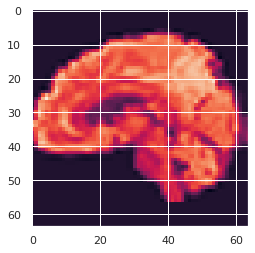

In [14]:
plt.imshow(images['FLAIR'][30])

In [15]:
def plot(mri_images):
    max_len=max([
        len(mri_images["FLAIR"]),
        len(mri_images["T1w"]),
        len(mri_images["T1wCE"]),
        len(mri_images["T2w"])
    ])

    fig, axes = plt.subplots(max_len,4,figsize=(2*4,2*max_len))
    
    for col,mri_type in enumerate(["FLAIR","T1w","T1wCE","T2w"]):
    
        for row in tqdm( range(len(mri_images[mri_type])) ):
            img=mri_images[mri_type][row,:,:]
            fig.add_subplot(max_len,4,4*row+col+1)
            plt.imshow(img)
            plt.axis("off")
            
            if row==0:plt.title(mri_type,fontsize=9)
            if col==0:plt.ylabel("row=" + str(row),fontsize=9)
    
    plt.show()

def create_animation(mri_images,mri_type):
    images=[]
    for image in mri_images[mri_type]:
        if image.max() != 0:images.append(image)

    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(images[0], cmap="gray")

    def animate_func(i):
        im.set_array(images[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = len(images), interval = 1000//24)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

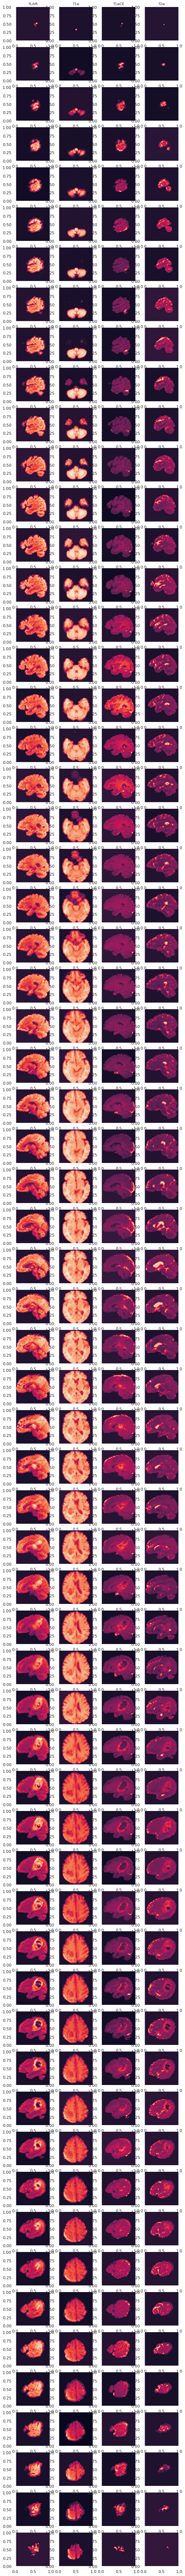

In [16]:
plot(images)

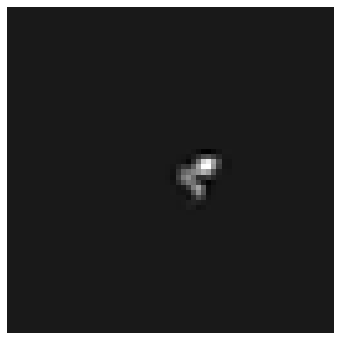

In [17]:
#images['FLAIR']=images['FLAIR'].transpose(1,0,2)
create_animation(images,"FLAIR")

In [18]:
images['FLAIR']
#images['FLAIR'][30][100]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [19]:
# class Model(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
#         n_features = self.net._fc.in_features
#         self.net._fc = torch.nn.Linear(in_features=n_features, out_features=1, bias=True)
#         #self.sigmoid=torch.nn.Sigmoid()
        
    
#     def forward(self, x):
        
#         #x (batch_size,channel,x,y,z)?
#         out = self.net(x)
#         return out#self.sigmoid(out)

# model=Model()
model=EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
n_features = model._fc.in_features
model._fc = torch.nn.Linear(in_features=n_features, out_features=1, bias=True)
model.to(CFG.device)
#model

EfficientNet3D(
  (_conv_stem): Conv3dStaticSamePadding(
    1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock3D(
      (_depthwise_conv): Conv3dStaticSamePadding(
        32, 32, kernel_size=(3, 3, 3), stride=[2, 2, 2], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
      )
      (_bn1): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv3dStaticSamePadding(
        32, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv3dStaticSamePadding(
        8, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv3dStaticS

In [20]:
# # del model
# # torch.cuda.empty_cache()
# # gc.collect()

# class Model(torch.nn.Module):


#     def __init__(self):
#         super().__init__()
#         self.conv=torch.nn.Sequential(
#             torch.nn.Conv3d(1,1,3,stride=2),
#             torch.nn.ReLU(),
#             torch.nn.Conv3d(1,2,5,stride=2),
#             torch.nn.ReLU(),
#             torch.nn.Conv3d(2,2,7,stride=2),
#             torch.nn.ReLU(),
#             torch.nn.Conv3d(2,2,7),
#             torch.nn.ReLU(),
#             torch.nn.Conv3d(2,4,3),
#             torch.nn.ReLU(),
#         )

#         self.fc=torch.nn.Sequential(
#             torch.nn.Linear(256,50),
#             torch.nn.ReLU(),
#             torch.nn.Linear(50,10),
#             torch.nn.ReLU(),
#             torch.nn.Linear(10,1),
#         )
        
#     def extract_feature(self,x):
#         return self.conv(x)
    
#     def forward(self,x):
#         x=self.conv(x)
#         x=x.flatten(start_dim=1)
#         x=self.fc(x)
        
#         return x
    
# model=Model()
# model.to(CFG.device)

In [21]:
# #model.eval()

# #torch.randn(1,1,64,512,512).dtype

# input_image=torch.tensor(images['T1w'],dtype=torch.float32).to(CFG.device).unsqueeze(0).unsqueeze(0)
# input_image.shape
# #o=model.extract_feature(input_image)
# plt.imshow(input_image[0,0,30,:,:])

# model.train()
# input_image,target=dataset['train'][3]
# input_image=input_image['FLAIR']
# input_image=torch.tensor(input_image,dtype=torch.float32).unsqueeze(0).unsqueeze(0)
# input_image.shape

# input_image=torch.randn(2,1,64,64,64).float()
# print(input_image.shape[0])
# o=model(input_image)
# o.shape

# # a=model.extract_features(input_image)
# # print(a.shape)
# # plt.imshow(a[0,4,0,:,:].detach().numpy())

# # print(model(torch.randn(1,1,64,512,512).to(CFG.device)))

In [22]:
def train_val_test(model,dataloader,phase,optimizer=None,scheduler=None,scaler=None):# モデルを学習させる関数
    
    #assert((phase=='train')==bool(optimizer))#学習時にoptimizer必須
    
    model.train() if phase=='train' else torch.no_grad()#model.eval()   # モデルのモード
    
    y=[]
    preds=[]
    losses=[]
    scores=[]
    
#     print('preprocess images')
#     #preprocessed=list(dataloader[phase])
#     print('end')
    
    # データローダーからミニバッチを取り出すループ
    for images,targets in tqdm(dataloader[phase]):
        
        if images.shape[0]==1:
            #なぜかバッチサイズが1になるとバグる
            print('batchsize==1')
            continue
        
        # optimizerを初期化
        if phase=='train':optimizer.zero_grad()
       
        # 順伝搬（forward）計算
        with torch.set_grad_enabled(phase=='train'):

#             with torch.cuda.amp.autocast():#HalfTensorになる？

            # non_blocking=TrueでPinned MemoryからGPUに転送中もCPUが動作できるらしい。
            images = images[:,0,:,:,:].unsqueeze(1).to(CFG.device,non_blocking=True)
            targets = targets.to(CFG.device,non_blocking=True)

            outputs = model(images).squeeze(1)
#             print(targets)
#             print(torch.nn.Sigmoid()(outputs))
            
            if phase!='test':
                loss_val = loss_fun(outputs, targets)  # 損失を計算
                losses.append(loss_val.item())

                #score.append(score)

                # 訓練時はバックプロパゲーション
                if phase == 'train':
                    loss_val.backward()
                    optimizer.step()
            

        preds.extend(outputs.detach().cpu().numpy())
        y.extend(targets.detach().cpu().numpy())
    
        
        
        del images,targets,outputs
        if phase!='test':del loss_val
        torch.cuda.empty_cache()
        gc.collect()
    
    return preds,losses,scores

In [23]:
loss_fun=torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)#, momentum=0.9)

0it [00:00, ?it/s]

batchsize==1


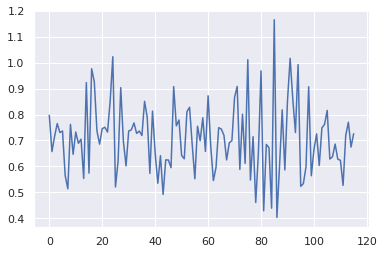

0it [00:00, ?it/s]

batchsize==1


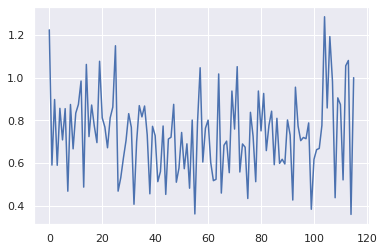

0it [00:00, ?it/s]

batchsize==1


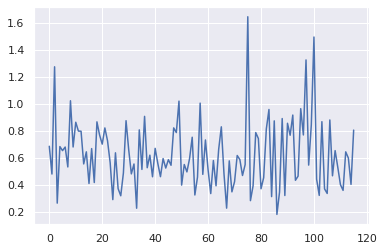

In [24]:
for i in range(3):
    preds,losses,scores=train_val_test(model,dataloader,'train',optimizer)
    plt.plot(losses)
    plt.show()

In [25]:
torch.save(model, 'model.pt')

In [26]:
#set_dataloader()
preds,losses,scores=train_val_test(model,dataloader,'test')

0it [00:00, ?it/s]

In [27]:
#preds=[1.0]*87
submission=labels['test'].drop('path',axis=1)

sigmoid=torch.nn.Sigmoid()
submission['MGMT_value']=sigmoid(torch.tensor(preds))
submission.to_csv("submission.csv",index='BraTS21ID')
submission

,MGMT_value
BraTS21ID,
1,0.241682
13,0.570763
15,0.776060
27,0.623863
37,0.190436
...,...
826,0.858996
829,0.356532
833,0.638569
